## 掛載雲端硬碟


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 更改檔案所在路徑

In [2]:
# Change to your own folder !!!
%cd /content/drive/MyDrive/Colab-AILAB/LAB2-Model_Pruning/

/content/drive/MyDrive/Colab-AILAB/LAB2-Model_Pruning


## Import library

In [3]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50


## 設定超參數

In [4]:
SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 20
LEARNING_RATE = 1e-3
LOG_INTERVAL = 100
CUDA = True

RESUME = True
START_EPOCH = 0

PRUNE_PATH = '/content/drive/MyDrive/Colab-AILAB/LAB2-Model_Pruning/model_prune.pth' # Change to your own folder !!!
PRUNE_FINETUNE_PATH = '/content/drive/MyDrive/Colab-AILAB/LAB2-Model_Pruning/model_prune_finetune.pth' # Change to your own folder !!!


#### 檢查是否檢查是否可使用GPU

In [5]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [6]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

## 載入剪枝後的網路與權重

In [7]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  cfg = checkpoint['cfg']
  model = ResNet50(num_classes=10,cfg=cfg)
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


## 設定 Optimizer & CrossEntropy Loss

In [8]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 定義訓練跟測試函數

In [12]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!

def train(epoch):
    model.train()
    correct = 0 #for train acc
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        total += target.size(0)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % LOG_INTERVAL == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.1f}%)] Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    train_acc_ratio = correct / float(total)
    print(f'Epoch: {epoch} Train Accuracy: {100. * train_acc_ratio:.2f}%')
    return train_acc_ratio

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)

          output = model(data)
          loss = criterion(output, target)
          test_loss += loss.item() * data.size(0)

          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))


best_prec1 = 0.
ft_train_accuracies = []
ft_test_accuracies = []
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本之十分之一
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    train_acc = train(epoch)
    prec1 = test()

    ft_train_accuracies.append(train_acc)
    ft_test_accuracies.append(prec1)

    # 儲存模型權重
    if(prec1 > best_prec1):
        best_prec1 = prec1
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
            'cfg': cfg
        }, PRUNE_FINETUNE_PATH)

    best_prec1 = max(prec1, best_prec1)

print('\n TRAIN PRUNED MODEL DONE!')



Train Epoch: 0 [0/50000 (0.0%)] Loss: 0.411999

Train Epoch: 0 [10000/50000 (20.0%)] Loss: 0.249169

Train Epoch: 0 [20000/50000 (40.0%)] Loss: 0.289043

Train Epoch: 0 [30000/50000 (60.0%)] Loss: 0.378602

Train Epoch: 0 [40000/50000 (80.0%)] Loss: 0.385475
Epoch: 0 Train Accuracy: 89.29%

Test set: Average loss: 0.4569, Accuracy: 8572/10000 (85.7%)


Train Epoch: 1 [0/50000 (0.0%)] Loss: 0.320006

Train Epoch: 1 [10000/50000 (20.0%)] Loss: 0.355477

Train Epoch: 1 [20000/50000 (40.0%)] Loss: 0.269653

Train Epoch: 1 [30000/50000 (60.0%)] Loss: 0.349856

Train Epoch: 1 [40000/50000 (80.0%)] Loss: 0.308165
Epoch: 1 Train Accuracy: 89.79%

Test set: Average loss: 0.4127, Accuracy: 8687/10000 (86.9%)


Train Epoch: 2 [0/50000 (0.0%)] Loss: 0.266903

Train Epoch: 2 [10000/50000 (20.0%)] Loss: 0.252069

Train Epoch: 2 [20000/50000 (40.0%)] Loss: 0.241239

Train Epoch: 2 [30000/50000 (60.0%)] Loss: 0.307030

Train Epoch: 2 [40000/50000 (80.0%)] Loss: 0.317970
Epoch: 2 Train Accuracy: 90.03

## 繪製Fine-tuning結果圖


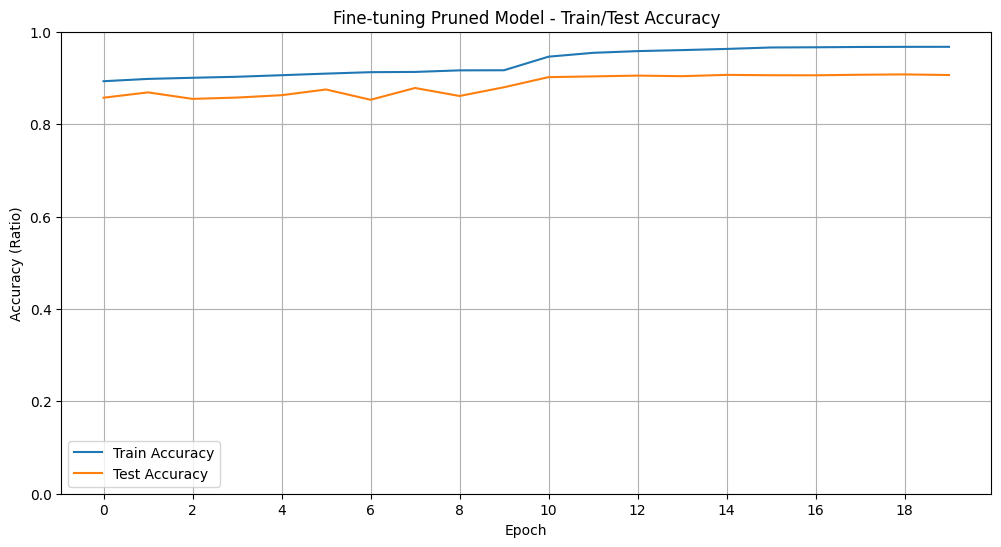

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(START_EPOCH, EPOCHS), ft_train_accuracies, label='Train Accuracy')
plt.plot(range(START_EPOCH, EPOCHS), ft_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (Ratio)')
plt.title('Fine-tuning Pruned Model - Train/Test Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
x_ticks = range(START_EPOCH, EPOCHS, 2)
plt.xticks(x_ticks)
plt.show()

## FLOPs & Parameters

In [14]:
!pip install thop
!pip install torchsummary

In [15]:
from thop import profile
from torchsummary import summary

##### 使用 thop 計算 FLOPs 和參數數量 #####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 134598948.0
Params: 3778198.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]           